In [1]:
%tensorflow_version 1.x #make sure you have tf version 1 otherwise this won't work
import tensorflow as tf

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x #make sure you have tf version 1 otherwise this won't work`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [2]:
print('Tensorflow version: {}'.format(tf.__version__) )

Tensorflow version: 1.15.2


In [3]:
!git clone https://github.com/NVlabs/stylegan2.git

fatal: destination path 'stylegan2' already exists and is not an empty directory.


In [4]:
%cd /content/stylegan2

/content/stylegan2


In [5]:
!pip install googledrivedownloader

In [6]:
import pretrained_networks
from google_drive_downloader import GoogleDriveDownloader as gdd

# links to the pre-trained anime StyleGAN weights 'https://drive.google.com/open?id=1BHeqOZ58WZ-vACR2MJkh1ZVbJK2B-Kle'
url = 'https://drive.google.com/open?id=1WNQELgHnaqMTq3TlrnDaVkyrAH8Zrjez'
model_id = url.replace('https://drive.google.com/open?id=', '')

network_pkl = '/content/models/model_%s.pkl' % model_id
gdd.download_file_from_google_drive(file_id=model_id,
                                    dest_path=network_pkl)

# it returns 3 networks, i will be mainly using Gs
# _G = instantaneous snapshot of the generator. mainly useful for resuming a previous training run.
# _D = instantaneous snapshot of the discriminator. mainly useful for resuming a previous training run.
# gen = long-term average of the generator. yields higher-quality results than the instantaneous snapshot.
_G, _D, gen = pretrained_networks.load_networks(network_pkl)

Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.


In [7]:
import numpy as np

#generate random vectors, to be used as the input fo our generator
def generate_vectors_from_seeds(seeds):
    vector_collection = []
    for seed_idx, seed in enumerate(seeds):
        rnd = np.random.RandomState(seed)
        random_vector = rnd.randn(1, *gen.input_shape[1:]) # [minibatch, component]
        vector_collection.append(random_vector)
    return vector_collection

In [8]:
!pip install tqdm

In [9]:
import dnnlib
import dnnlib.tflib as tflib
import PIL.Image
from tqdm import tqdm

# get tf noise variables for the stochastic variation
noise_vars = [var for name, var in gen.components.synthesis.vars.items() if name.startswith('noise')]

def generate_images(vector_collection, truncation_psi):
    gen_kwargs = dnnlib.EasyDict()
    gen_kwargs.output_transform = dict(func = tflib.convert_images_to_uint8, nchw_to_nhwc = True)
    gen_kwargs.randomize_noise = False
    if not isinstance(truncation_psi, list):
        truncation_psi = [truncation_psi] * len(vector_collection)
        
    imgs = []
    for random_vector_idx, random_vector in tqdm(enumerate(vector_collection)):
        gen_kwargs.truncation_psi = truncation_psi[random_vector_idx]
        noise_rnd = np.random.RandomState(1) # fix noise
        tflib.set_vars({var: noise_rnd.randn(*var.shape.as_list()) for var in noise_vars}) # [height, width]
        images = gen.run(random_vector, None, **gen_kwargs) # [minibatch, height, width, channel]
        imgs.append(PIL.Image.fromarray(images[0], 'RGB'))
    return imgs

def generate_images_from_seeds(seeds, truncation_psi):
    return generate_images(generate_vectors_from_seeds(seeds), truncation_psi)

In [10]:
# generate some random seeds
seeds = np.random.randint(10000000, size = 9)
print(seeds)

vector_collection = generate_vectors_from_seeds(seeds)
imgs = generate_images(vector_collection, .7)

0it [00:00, ?it/s]

[4997668  576176  996057 1971680 5667859 5245601 4288840  544745 3880070]


9it [00:05,  1.58it/s]


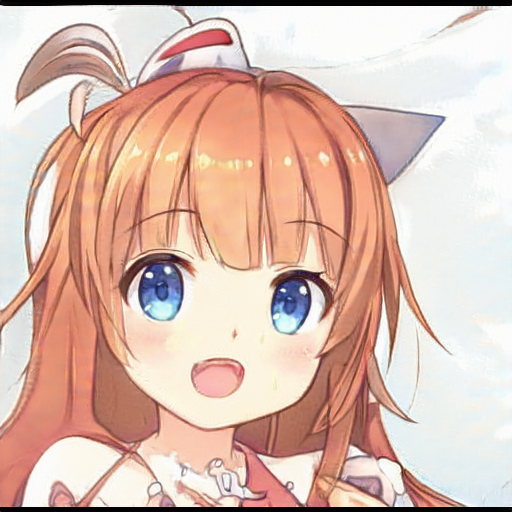

In [11]:
imgs[0]

In [12]:
from math import ceil

def createImageGrid(images, scale=0.25, rows=1):
   w,h = images[0].size
   w = int(w * scale)
   h = int(h * scale)
   height = rows * h
   cols = ceil(len(images) / rows)
   width = cols * w
   canvas = PIL.Image.new('RGBA', (width,height), 'white')
   for i, img in enumerate(images):
     img = img.resize((w, h), PIL.Image.ANTIALIAS)
     canvas.paste(img, (w * (i % cols), h * (i // cols))) 
   return canvas

In [13]:
def interpolate(vector_collection, steps):
   out = []
   for i in range(len(vector_collection) - 1):
    for index in range(steps):
     fraction = index/float(steps) 
     out.append(vector_collection[i+1] * fraction + vector_collection[i] * (1-fraction))
   return out

In [14]:
seeds = np.random.randint(10000000, size = 2)
vector_collection = generate_vectors_from_seeds(seeds)
imgs = generate_images(interpolate(vector_collection, 7), 0.5)

7it [00:01,  4.03it/s]


7it [00:00, 14.09it/s]


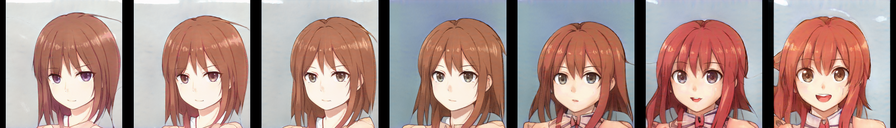

In [15]:
seeds = np.random.randint(10000000, size = 2)
vector_collection = generate_vectors_from_seeds(seeds)
imgs = generate_images(interpolate(vector_collection, 7), 0.5)
createImageGrid(imgs, rows = 1)

In [20]:
import scipy

grid_size = [3, 3]
image_shrink = 1
image_zoom = 1
duration_sec = 5
smoothing_sec = 1.0
fps = 15
codec = 'libx264'
bitrate = '2M' #4M
random_seed = np.random.randint(0, 999) #405
filename = 'random_grid_%s.gif' % random_seed
truncation_psi= 0.7

num_frames = int(np.rint(duration_sec * fps))
random_state = np.random.RandomState(random_seed)

# generate latent vectors
shape = [num_frames, np.prod(grid_size)] + gen.input_shape[1:] # [frame, image, channel, component]
all_latents = random_state.randn(*shape).astype(np.float32)
all_latents = scipy.ndimage.gaussian_filter(all_latents, [smoothing_sec * fps] + [0] * len(gen.input_shape), mode = 'wrap')
all_latents /= np.sqrt(np.mean(np.square(all_latents)))


def create_image_grid(images, grid_size=None):
    assert images.ndim == 3 or images.ndim == 4
    num, img_h, img_w, channels = images.shape

    if grid_size is not None:
        grid_w, grid_h = tuple(grid_size)
    else:
        grid_w = max(int(np.ceil(np.sqrt(num))), 1)
        grid_h = max((num - 1) // grid_w + 1, 1)

    grid = np.zeros([grid_h * img_h, grid_w * img_w, channels], dtype=images.dtype)
    for idx in range(num):
        x = (idx % grid_w) * img_w
        y = (idx // grid_w) * img_h
        grid[y : y + img_h, x : x + img_w] = images[idx]
    return grid

# frame generation func for moviepy.
def make_frame(t):
    frame_idx = int(np.clip(np.round(t * fps), 0, num_frames - 1))
    latents = all_latents[frame_idx]
    fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    images = gen.run(latents, None, truncation_psi=truncation_psi,
                          randomize_noise=False, output_transform=fmt, 
                          minibatch_size=16)

    grid = create_image_grid(images, grid_size)
    if image_zoom > 1:
        grid = scipy.ndimage.zoom(grid, [image_zoom, image_zoom, 1], order=0)
    if grid.shape[2] == 1:
        grid = grid.repeat(3, 2) # grayscale => RGB
    return grid

# generate video.
import moviepy.editor
video_clip = moviepy.editor.VideoClip(make_frame, duration=duration_sec)

video_clip.write_gif(filename,fps = 15)

# use this if you want to generate .mp4 video instead
video_clip.write_videofile("interpolate3x2-2m.mp4", fps=fps, codec=codec, bitrate=bitrate)

[MoviePy] >>>> Building video interpolate3x2-2m.mp4
[MoviePy] Writing video interpolate3x2-2m.mp4


 99%|█████████▊| 75/76 [00:33<00:00,  2.27it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: interpolate3x2-2m.mp4 


[MoviePy] Building file random_grid_280.gif with imageio


 99%|█████████▊| 75/76 [01:22<00:01,  1.10s/it]


In [21]:
from IPython import display as ipythondisplay
import io
import os
import base64
from IPython.display import HTML

def show_video(vid):
  ext = os.path.splitext(vid)[-1][1:]
  video = io.open(vid, 'r+b').read()
  ipythondisplay.display(HTML(data = '''<video alt = "test" autoplay 
              loop controls style = "height: 400px;">
              <source src = "data:video/{1}';base64,{0}" type = "video/{1}" />
              </video>'''.format(base64.b64encode(video).decode('ascii'), ext)))
  
show_video(filename)